## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

In [2]:
from random import sample
import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import math

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
29210,00007620_000.png,No Finding,0,7620,23,F,AP,3056,2544,0.139000,0.139000,NaN,/data/images_004/images/00007620_000.png
111979,00030706_000.png,No Finding,0,30706,56,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030706_000.png
18880,00005015_002.png,No Finding,2,5015,57,M,PA,2500,2048,0.171000,0.171000,NaN,/data/images_003/images/00005015_002.png


In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].apply(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].apply(lambda x: 'Y' if x==1 else "N")
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
33211,00008705_001.png,No Finding,1,8705,50,F,PA,2992,2991,0.143,...,0,0,0,0,1,0,0,0,0,N
35248,00009304_000.png,No Finding,0,9304,35,M,PA,2500,2048,0.168,...,0,0,0,0,1,0,0,0,0,N
37658,00009912_003.png,No Finding,3,9912,27,M,AP,2500,2048,0.168,...,0,0,0,0,1,0,0,0,0,N


## Create your training and testing data:

In [6]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_df, valid_df = skl.train_test_split(df, test_size=0.2, stratify=df['Pneumonia'])
    
    p_idx = train_df[train_df.Pneumonia==1].index.tolist()
    nop_idx = train_df[train_df.Pneumonia==0].index.tolist()
    nop_sample = sample(nop_idx, len(p_idx))
    train_df = train_df.loc[p_idx + nop_sample]
    train_df_ratio = len(train_df[train_df.Pneumonia==1])/len(train_df)
    print(f'Percentage of Pneumonia samples in training set: {100.0*train_df_ratio :.2f}%')
    
    p_idx = valid_df[valid_df.Pneumonia==1].index.tolist()
    nop_idx = valid_df[valid_df.Pneumonia==0].index.tolist()
    nop_sample = sample(nop_idx, 4*len(p_idx))
    valid_df = valid_df.loc[p_idx + nop_sample]
    valid_df_ratio = len(valid_df[valid_df.Pneumonia==1])/len(valid_df)
    print(f'Percentage of Pneumonia samples in validation set: {100.0*valid_df_ratio :.2f}%')

    return train_df, valid_df
    

In [7]:
train_df, valid_df = create_splits(all_xray_df)

Percentage of Pneumonia samples in training set: 50.00%
Percentage of Pneumonia samples in validation set: 20.00%


In [8]:
len(train_df)

2290

In [9]:
len(valid_df)

1430

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
def my_image_augmentation(data_type):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    if data_type == 'train':
        return ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    if data_type == 'valid':
        return ImageDataGenerator(rescale=1. / 255.0)
    
    return my_idg


In [9]:
def make_gen(data_type, df, batch_size, IMAGE_SIZE=(224, 224)):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    

    aug = my_image_augmentation(data_type)
    gen = aug.flow_from_dataframe(
        dataframe = df, 
        directory = None, 
        x_col = 'path',
        y_col = 'pneumonia_class',
        class_mode = 'binary',
        target_size = IMAGE_SIZE, 
        batch_size = batch_size)

    return gen




In [10]:
train_gen = make_gen('train', train_df, 32)
val_gen = make_gen('valid', valid_df, 32)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [11]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

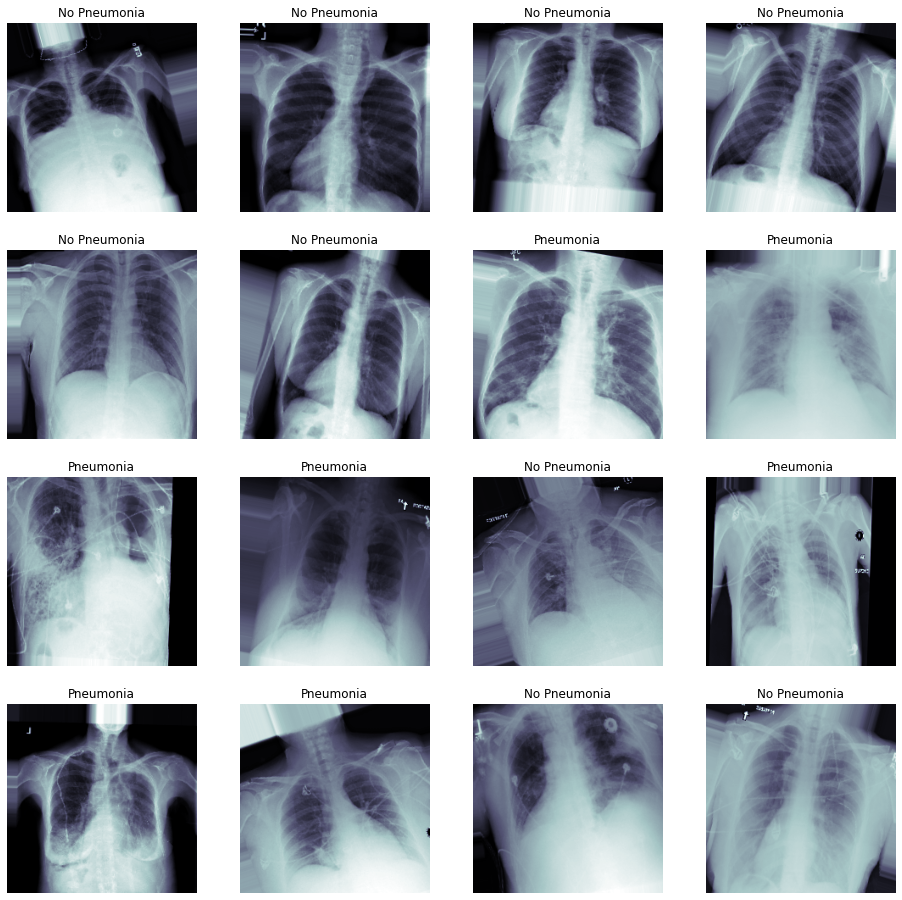

In [12]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [13]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model


In [14]:
vgg_model = load_pretrained_model()
vgg_model.summary()

553467904/553467096 [==============================] - 7s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [15]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    model = Sequential()
    model.add(vgg_model)
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    return model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [16]:
model = build_my_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 40,406,849
Trainable params: 28,051,969
Non-trainable params: 12,354,880
_________________________________

In [17]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only = True)

early = EarlyStopping(monitor='val_loss', 
                      mode='min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [18]:
optimizer = Adam(lr=1e-4) 
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [19]:
## train your model

history = model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10, 
                          callbacks = callbacks_list)

Epoch 1/10
72/72 [==============================] - 64s 884ms/step - loss: 0.7719 - binary_accuracy: 0.5550 - val_loss: 0.6642 - val_binary_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 0.66422, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
72/72 [==============================] - 57s 798ms/step - loss: 0.6749 - binary_accuracy: 0.5886 - val_loss: 0.6581 - val_binary_accuracy: 0.6562

Epoch 00002: val_loss improved from 0.66422 to 0.65812, saving model to xray_class_my_model.best.hdf5
Epoch 3/10
72/72 [==============================] - 60s 827ms/step - loss: 0.6511 - binary_accuracy: 0.6214 - val_loss: 0.4388 - val_binary_accuracy: 0.8438

Epoch 00003: val_loss improved from 0.65812 to 0.43877, saving model to xray_class_my_model.best.hdf5
Epoch 4/10
72/72 [==============================] - 60s 828ms/step - loss: 0.6403 - binary_accuracy: 0.6380 - val_loss: 0.5805 - val_binary_accuracy: 0.7188

Epoch 00004: val_loss did not improve from 0.43877
Epoch 5/10
72/7

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [20]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
val_gen = make_gen('valid', valid_df, 1430)
valX, valY = val_gen.next()
model.load_weights(weight_path)
pred_Y = model.predict(valX, verbose = True)

Found 1430 validated image filenames belonging to 2 classes.
1430/1430 [==============================] - 15s 11ms/step


In [21]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')    
    plt.show()
    

## what other performance statistics do you want to include here besides AUC? 
def plot_pr(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(recall, precision, color='red', lw=2)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    return 2*(precision*recall)/(precision + recall), precision, recall, thresholds
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    f = plt.figure()
    f.set_figwidth(10)
    f.add_subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()

    f.add_subplot(1, 2, 2)
    plt.plot(history.history['val_binary_accuracy'], label='val accuracy')
    plt.plot(history.history['binary_accuracy'], label='train accuracy')
    plt.legend()

    plt.show()

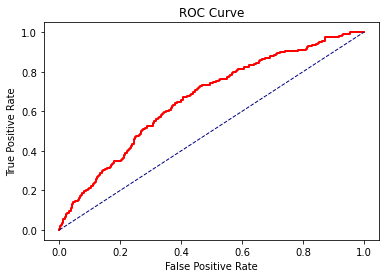

In [22]:
## plot figures

plot_auc(valY, pred_Y)

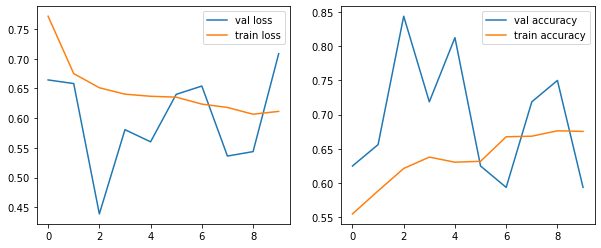

In [23]:
plot_history(history)

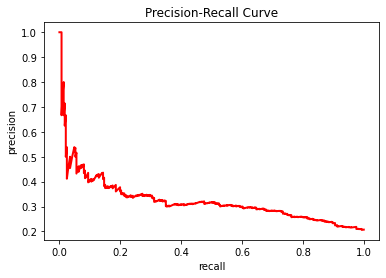

In [24]:
f1, prec, recall, thresholds = plot_pr(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [25]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

metric_df = pd.DataFrame({'f1':f1[:-1], 'prec':prec[:-1], 'recall':recall[:-1], 'thresholds':thresholds})

In [26]:
metric_df

,f1,prec,recall,thresholds
0,0.343337,0.207246,1.000000,0.089040
1,0.342342,0.206672,0.996503,0.089765
2,0.341346,0.206096,0.993007,0.090152
3,0.341551,0.206245,0.993007,0.090815
4,0.341757,0.206395,0.993007,0.091211
...,...,...,...,...
1375,0.027491,0.800000,0.013986,0.619027
1376,0.020690,0.750000,0.010490,0.626559
1377,0.013841,0.666667,0.006993,0.634596
1378,0.013889,1.000000,0.006993,0.654358


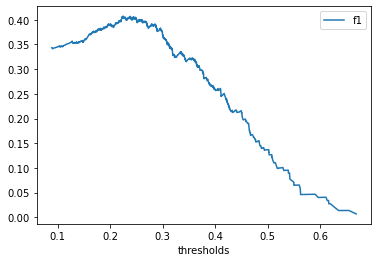

In [27]:
metric_df.plot(x ='thresholds', y='f1', kind = 'line')


In [28]:
print('Maximum f1:', metric_df['f1'].max())
threshold = metric_df.iloc[metric_df['f1'].idxmax()]['thresholds']
print('Threshold:', threshold)

Maximum f1: 0.4070450097847358
Threshold: 0.22431683540344238


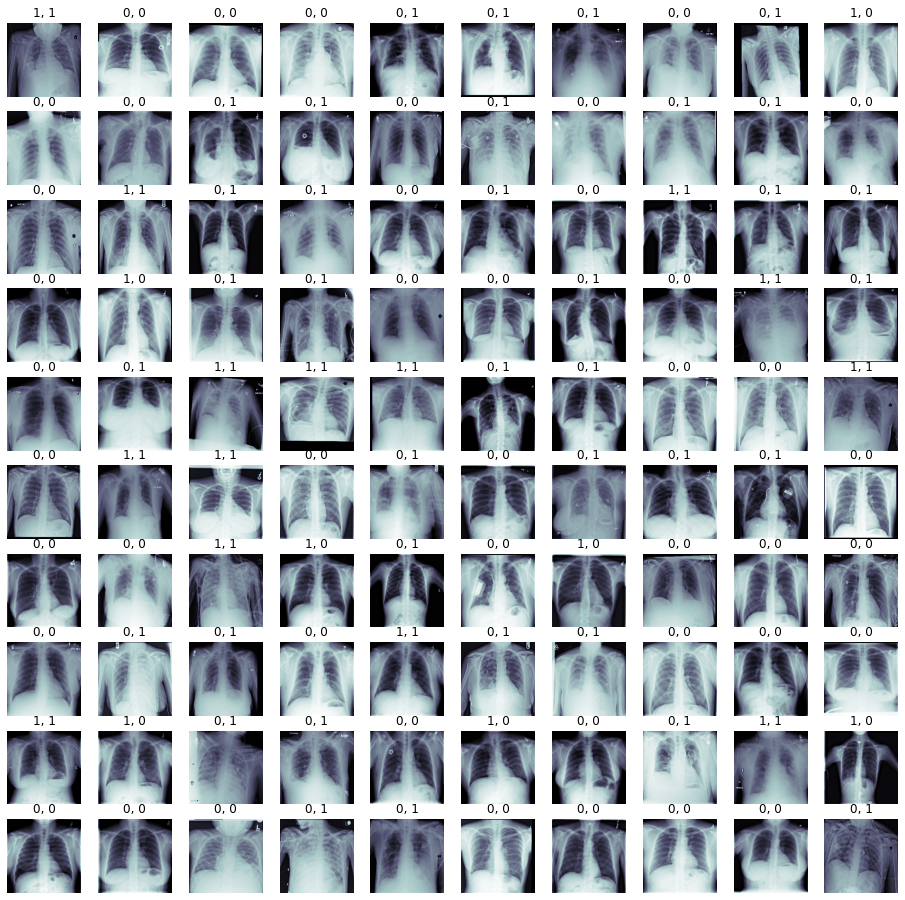

In [29]:
## Let's look at some examples of true vs. predicted with our best model: 


fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold :
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold : 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [30]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)